In [13]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [2]:
def moving_average(a, n=10): 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret/=n
    # Masking
    ret[:n-1]=ret[n-1]
    ret=ret.reshape(-1,1)
    return ret

def read_train_patients(input_len = 8, output_len = 6):
    x_train=[]
    y_train=[]
    #y_train_f=[]
    for i in range(1, 16):
        #y_noised=[]
        
        df=pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
        dataset=df.values
        #dataset = moving_average(dataset)

        scaler = MinMaxScaler(feature_range=(0, 1)) 
        scaled_data = scaler.fit_transform(dataset)
        train_data = scaled_data
        #train_data = dataset
        
        for i in range(input_len,len(train_data)-output_len):
            x_train.append(train_data[i-input_len:i,0])
            y_train.append(train_data[i+output_len-1,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    #reshape 
    #x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    print(x_train.shape)
    print(y_train.shape)
    return scaler, x_train, y_train

In [4]:
def train_model_SVR(x_train, y_train):
    
    X_val = x_train[11000:]
    Y_val = y_train[11000:]
    X_train = x_train[:11000]
    Y_train = y_train[:11000]

    #SVR model
    svr = SVR()
    
    # find best hyperparams
    grid_params = {
        'kernel': ['rbf'],
        'C':[100, 10**3, 10**4],
        'gamma':['auto']
    }
    
    grid_cv = GridSearchCV(svr, grid_params, verbose = 1, cv=5, n_jobs=-1)
    gs_results = grid_cv.fit(X_train, Y_train)
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    
    svr = SVR(kernel=gs_results.best_params_['kernel'],C=gs_results.best_params_['C'], gamma=gs_results.best_params_['gamma'])
    svr.fit(X_train, Y_train)
    
    
    #validation
    pred=svr.predict(X_val)
    error = np.sqrt(mean_squared_error(Y_val,pred))
    print('RMSE:', error)
    
    #plotting the rmse values against k values
    """curve = pd.DataFrame(rmse_val) #elbow curve 
    plt.figure(figsize=(24,16))
    plt.title('RMSE according to the Num of Neighbors(K)',fontsize=40)
    plt.plot(curve, linewidth=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel('value of K',fontsize=28)
    plt.ylabel('RMSE',fontsize=28)"""
    
    #validation
    #prediction = knn.predict(X_val)
    #r_squared = knn.score(X_val, Y_val)#?
    #rmse = np.sqrt(mean_squared_error(prediction, Y_val))
    #accuracy = metrics.accuracy_score(Y_val, prediction)
    #print("val_rmse: ", rmse)
    #print("accuracy: ", accuracy)
    return svr


In [11]:
#random forest
def train_model_RFR(x_train, y_train, n_estimators=1000):
    X_val = x_train[11000:]
    Y_val = y_train[11000:]
    X_train = x_train[:11000]
    Y_train = y_train[:11000]

    #random_forest = RandomForestRegressor(n_estimators=n_estimators,random_state=100,oob_score=True)
    #random_forest.fit(X_train, Y_train)
    
    random_forest = RandomForestRegressor()
        
    #find best hyperparams
    param_grid = {
    'n_estimators': [235, 500, 530, 525, 600],
    'max_depth': [8, 10, 12],
    'min_samples_split': [1, 2],
    'max_features': ['auto', 'sqrt'],
    }
    
    grid_cv = GridSearchCV(random_forest, param_grid=param_grid, cv=2, n_jobs=-1)
    gs_results = grid_cv.fit(X_train,Y_train)
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    
    random_forest = RandomForestRegressor(n_estimators=gs_results.best_params_['n_estimators'],random_state=0,oob_score=False)
    random_forest.fit(X_train, Y_train)
    
    """curve = pd.DataFrame(rmse_val) #elbow curve 
    print(curve)
    plt.figure(figsize=(24,16))
    plt.title('RMSE according to the Num of Neighbors(K)',fontsize=40)
    plt.plot(curve, linewidth=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel('value of K',fontsize=28)
    plt.ylabel('RMSE',fontsize=28)"""
    
    #validation
    prediction = random_forest.predict(X_val)
    r_squared = random_forest.score(X_val, Y_val)
    error = np.sqrt(mean_squared_error(Y_val,prediction))
    print('RMSE: ',error )
    
    return random_forest


In [5]:
scaler, x_train, y_train = read_train_patients()

(12750, 8)
(12750,)


In [6]:
svr = train_model_SVR(x_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished


0.809912005846947
SVR(C=10000, gamma='auto')
{'C': 10000, 'gamma': 'auto', 'kernel': 'rbf'}
RMSE: 0.0963553173823605


In [14]:
random_forest = train_model_RFR(x_train, y_train) 

exception calling callback for <Future at 0x23fc88e9e20 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 531, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [7]:
def show_plots(i, continuous_ytest, continuous_predictions):
    plt.figure(figsize=(24,16))
    plt.title('Blood Glucose Prediction Model Result_patient_{}'.format(i),fontsize=40)
    plt.plot(continuous_ytest, color = 'b', linewidth=3)
    plt.plot(continuous_predictions, color = 'r', ls="--", linewidth=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.ylim(40, 260)
    ax=plt.axes()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.xlabel('Timestamp',fontsize=28)
    plt.ylabel('BG(CGM) (mg/dL)',fontsize=28)
    plt.legend(['Real','Predictions'], loc='upper right',fontsize=32)
    plt.show()

In [8]:
def test_model(model, i, input_len=8, output_len=6):
    df = pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
    dataset=df.values
    
    #dataset = moving_average(dataset)
    
    # Scalling data from 0 - 1 to input in the neural network
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_data = scaler.fit_transform(dataset)
    
    x_test =[]
    y_test =[]
    
    continuous_ytest=[]
    i= input_len
    
    for i in range(input_len,len(dataset)-output_len):
        x_test.append(scaled_data[i-input_len:i,0])
        y_test.append(dataset[i+output_len-1,0])
        continuous_ytest.append(dataset[i+output_len-1,0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
  
    #x_test= np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    predictions = model.predict(x_test)
    print(predictions.shape)
    predictions = np.reshape(predictions,(1,-1))
    predictions = scaler.inverse_transform(predictions)
    print(predictions)
    print(y_test)
    #print("predictions: ", predictions)
    
    continuous_predictions = predictions[0]
    for i in range(1, len(predictions)):
        continuous_predictions = np.concatenate([continuous_predictions, predictions[i]])
    
    #print(predictions)
    #print(y_test)
    
    
    rmse=np.sqrt(np.mean(((predictions[0]-y_test)**2)))
    mape=np.mean(np.abs((predictions[0]-y_test)/y_test)*100)
    
    return rmse, mape, continuous_ytest, continuous_predictions

(850,)
[[131.35369819 128.70431499 124.96272213 115.69122483 117.61406973
  123.91186002 114.79476466 111.24801091 109.32400053 112.62134926
  102.28205148 106.24059661  99.66546263 108.36225617 114.23089932
  113.25861839 110.88791004 117.33805189 105.82933388 123.53160526
  122.81854984 131.65395725 133.65983745 136.24212862 134.43306762
  134.72445625 127.26204925 117.36581674 127.18695251 138.33646612
  132.44561583 143.35423763 141.4361594  149.26028951 141.38609856
  124.27294809 117.72228812 126.93264651 124.50937559 118.77161186
  117.16871212 114.09733955 116.15497148 106.83301668 114.67664485
  112.40562082 113.83978866 118.68094446 129.94872028 125.1829375
  128.29011111 133.96830654 130.05599125 121.82562759 118.95994365
  117.51926107 120.64063325 115.19784411 122.38037606 143.51662096
  148.55626662 131.22448104 120.85118321 120.26542299 118.14709817
  128.38531479 125.37949624 126.11503573 134.97209631 139.96103842
  125.2759746  127.29221225 117.83643906 119.96885913 12

<ipython-input-7-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


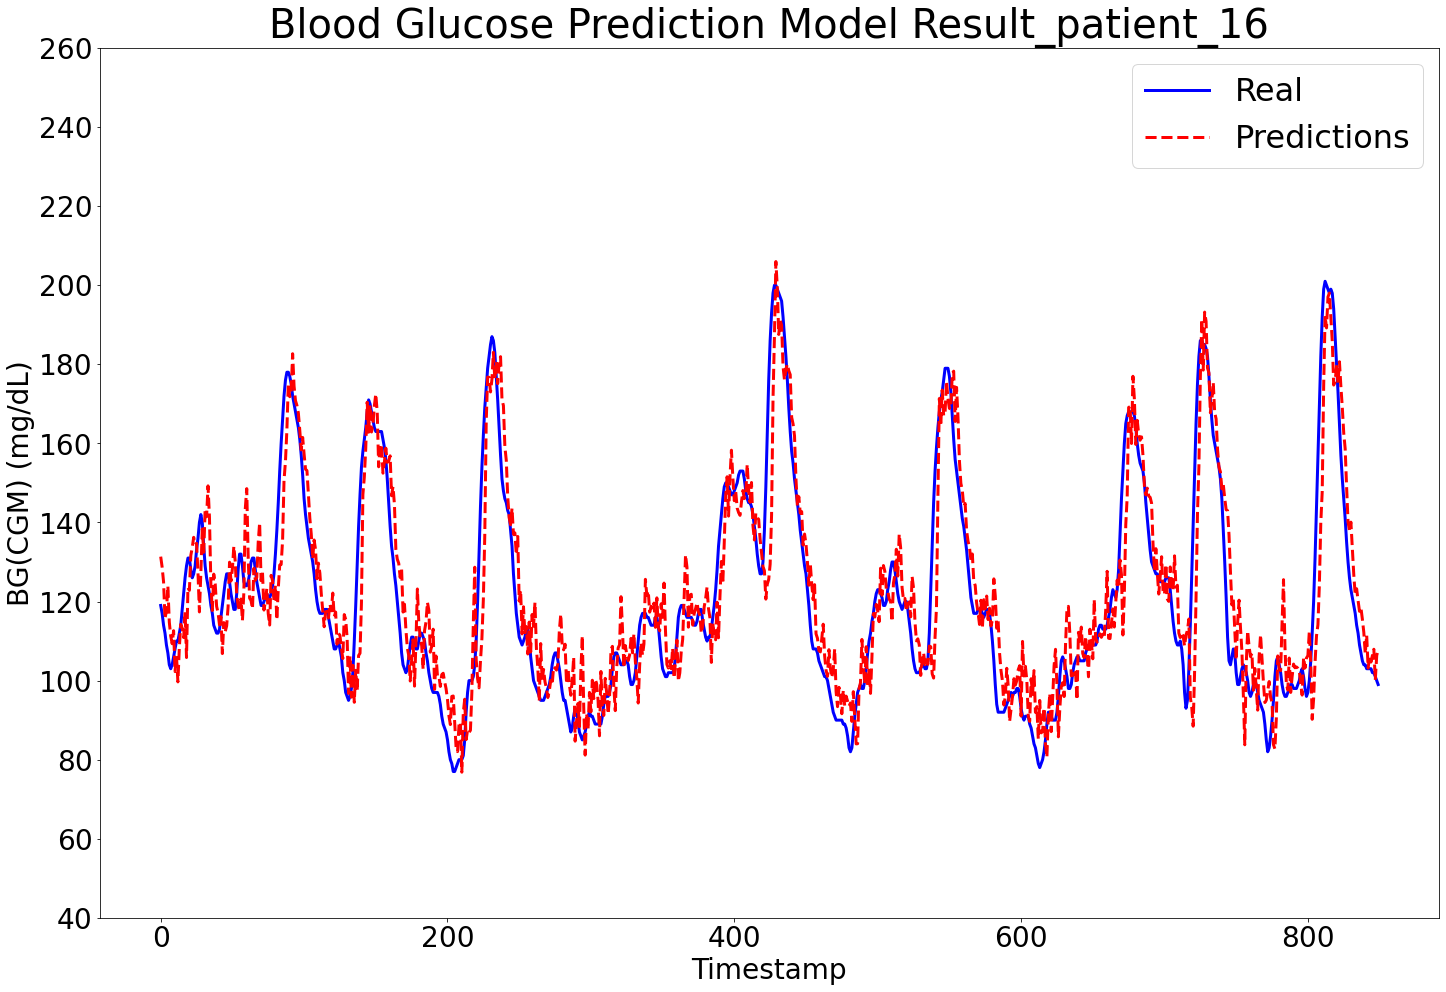

0.929711415044704
0.9583368292368094
0.9740175731607318
Time_delay(min):  15
Root-Mean-Squared Deviation 12.570691727576328
Mean-Absolute-Percentage-Error 7.68592819630637
(850,)
[[111.20532997 113.70590436 121.03049247 117.9012342  110.81408132
  110.94767506 103.91440052 106.52340701 111.21174541 109.21220583
  103.24849775 115.9762888  124.02066477 109.37791816 108.00140826
  119.18844834 105.12037884 108.56630035 113.70898842 109.39205361
  113.02474077 124.56912807 116.61695559 117.00030561 122.94468477
  123.86785422 117.70765314 117.28115563 116.0220725  112.24935116
  113.15993563 112.09954968 114.10140247 110.22207682 113.86525908
  111.72924788 104.53242724 107.73811133 109.693429   105.83420866
  105.87395406 118.20944161 105.36507521 111.62487195 108.41757437
  108.72954554 103.58809413 113.69747579 103.52281596  99.25789636
   92.85755845  98.7266495  110.29151085 122.38088793 135.60348951
  129.50052257 119.45079122 121.56626183 125.30643954 121.34893924
  132.46873194 12

<ipython-input-7-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


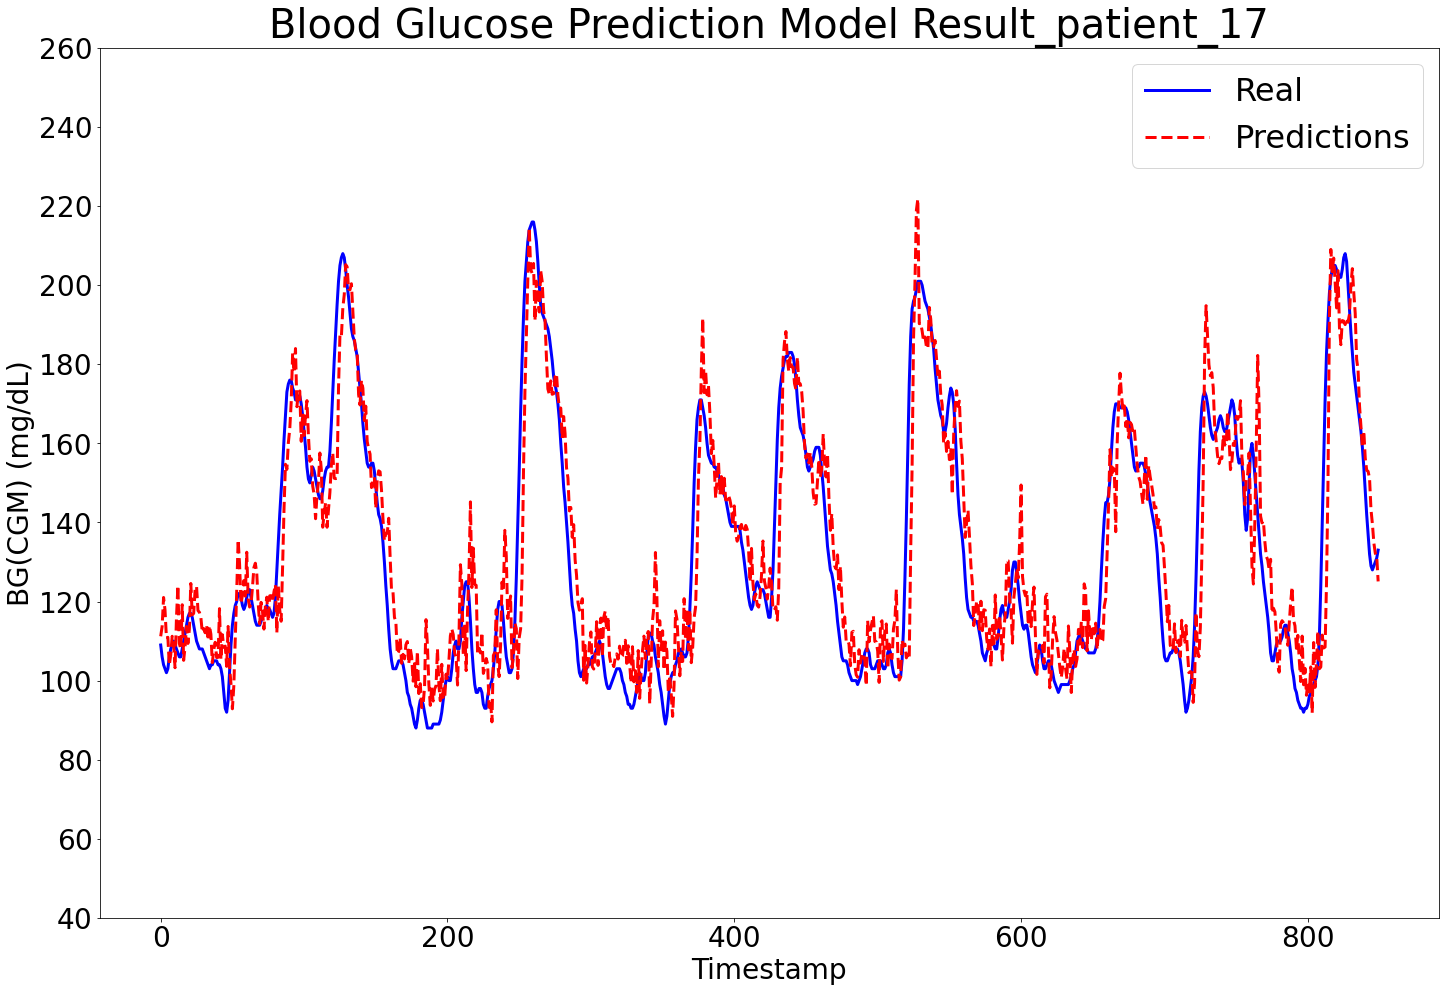

0.9384555213683978
0.9615046510859999
0.9742666599897674
Time_delay(min):  15
Root-Mean-Squared Deviation 13.653389536067923
Mean-Absolute-Percentage-Error 7.7587719115581795
(850,)
[[135.68002952 141.24737267 144.04319044 133.38016148 135.54464222
  137.36927212 128.66783891 134.52927476 128.8031813  131.2421506
  125.59088952 129.74049391 127.48145923 120.18968241 116.08364564
  114.61568841 116.29567503 116.28533013 120.43719792 121.25460947
  118.7445459  120.20452008 123.06444787 122.67438155 130.32518627
  123.73394024 126.20064246 124.41267073 119.76119173 127.59336406
  114.8989186  125.95854455 125.78353837 131.62393238 117.43056895
  123.64067597 120.57055505 120.57330066 130.14481265 133.42694769
  121.89004856 123.24951106 112.12847253 115.76801403 115.59032195
  109.86071197 112.40003973 126.8791978  121.36354307 111.08262234
  113.4369577  107.685311   109.4542096  121.40406176 113.58794648
  110.47162306 121.8098196  118.23626887 121.63889989 137.3925864
  140.76155552 1

<ipython-input-7-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


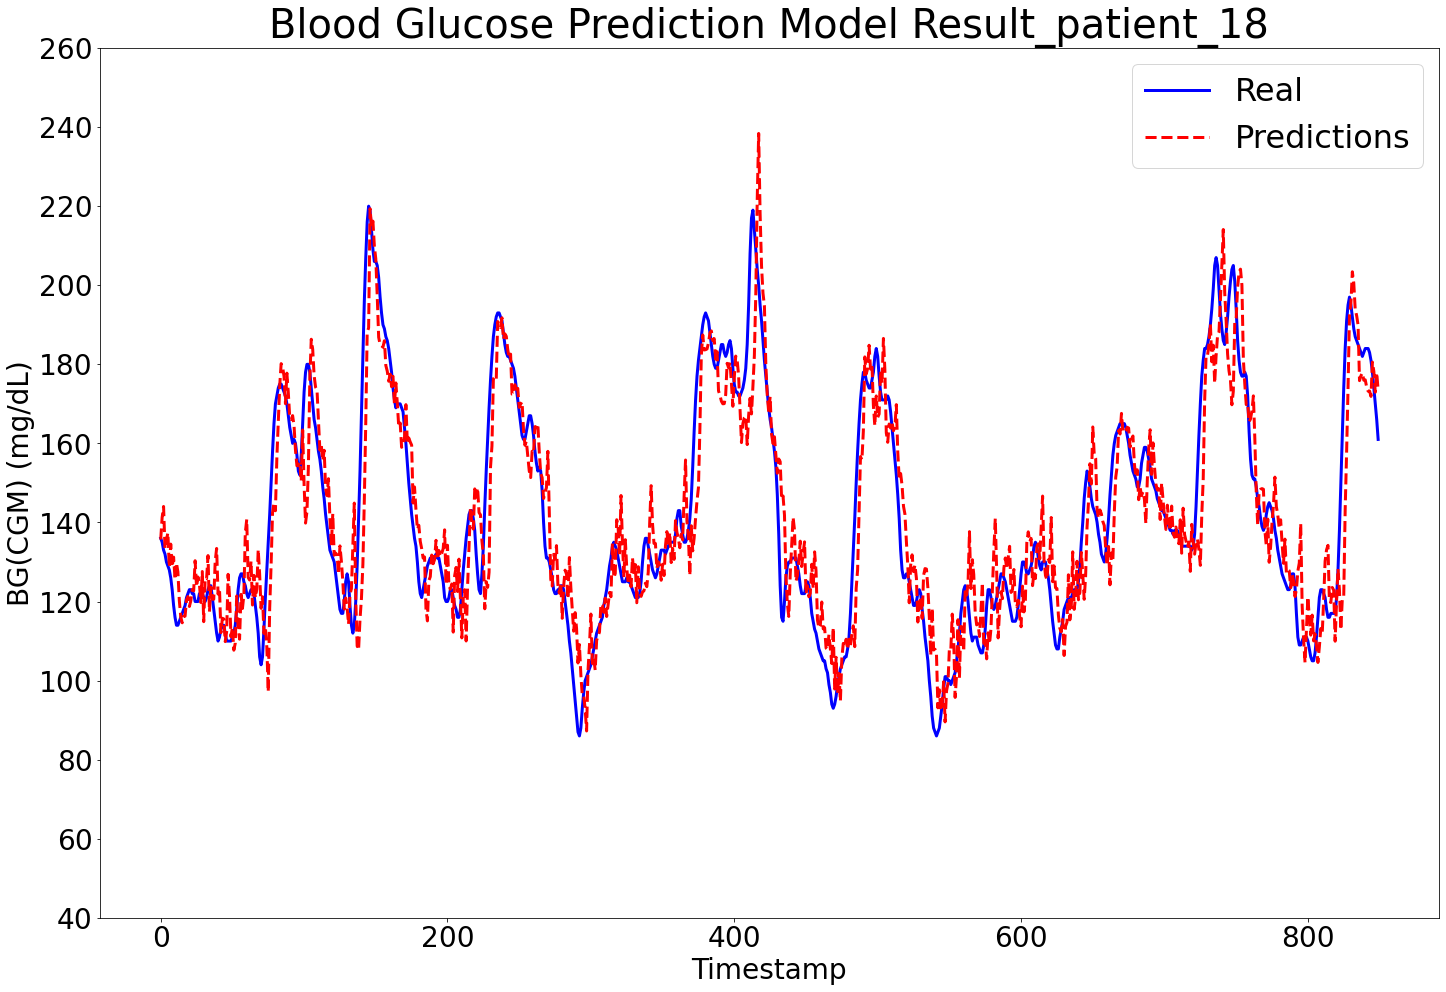

0.9278354114772946
0.9551197999157682
0.9729139981423979
0.9755953786063675
Time_delay(min):  20
Root-Mean-Squared Deviation 12.822609219424688
Mean-Absolute-Percentage-Error 6.707533510425744
(850,)
[[110.42963372 107.39700224 108.01615669 106.58222065 105.10298179
  110.29558786 113.6734532  103.59901335 113.08523114 108.6765566
  107.30410766  99.41881504  93.06207195 104.75800752 108.82429702
  108.90225099 121.14813519 121.5155152  129.59691636 128.04242248
  114.10465658 109.80220145 117.06085653 116.49304287 105.31527137
  117.34646934 116.25062104 110.36540473 118.57335966 124.1450357
  120.19025176 117.94462438 112.01097803 116.03899787 115.09776524
  116.84945632 126.59140397 123.7339154  135.6975928  131.84524406
  139.41273213 144.48858674 145.1506836  132.87676884 131.49982373
  126.68178627 125.16508918 130.79887713 130.1039791  131.60476254
  127.57452387 128.85975365 129.95853263 144.85772621 147.27889192
  134.98969466 129.41729765 123.5462079  123.31884722 123.6109436

<ipython-input-7-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


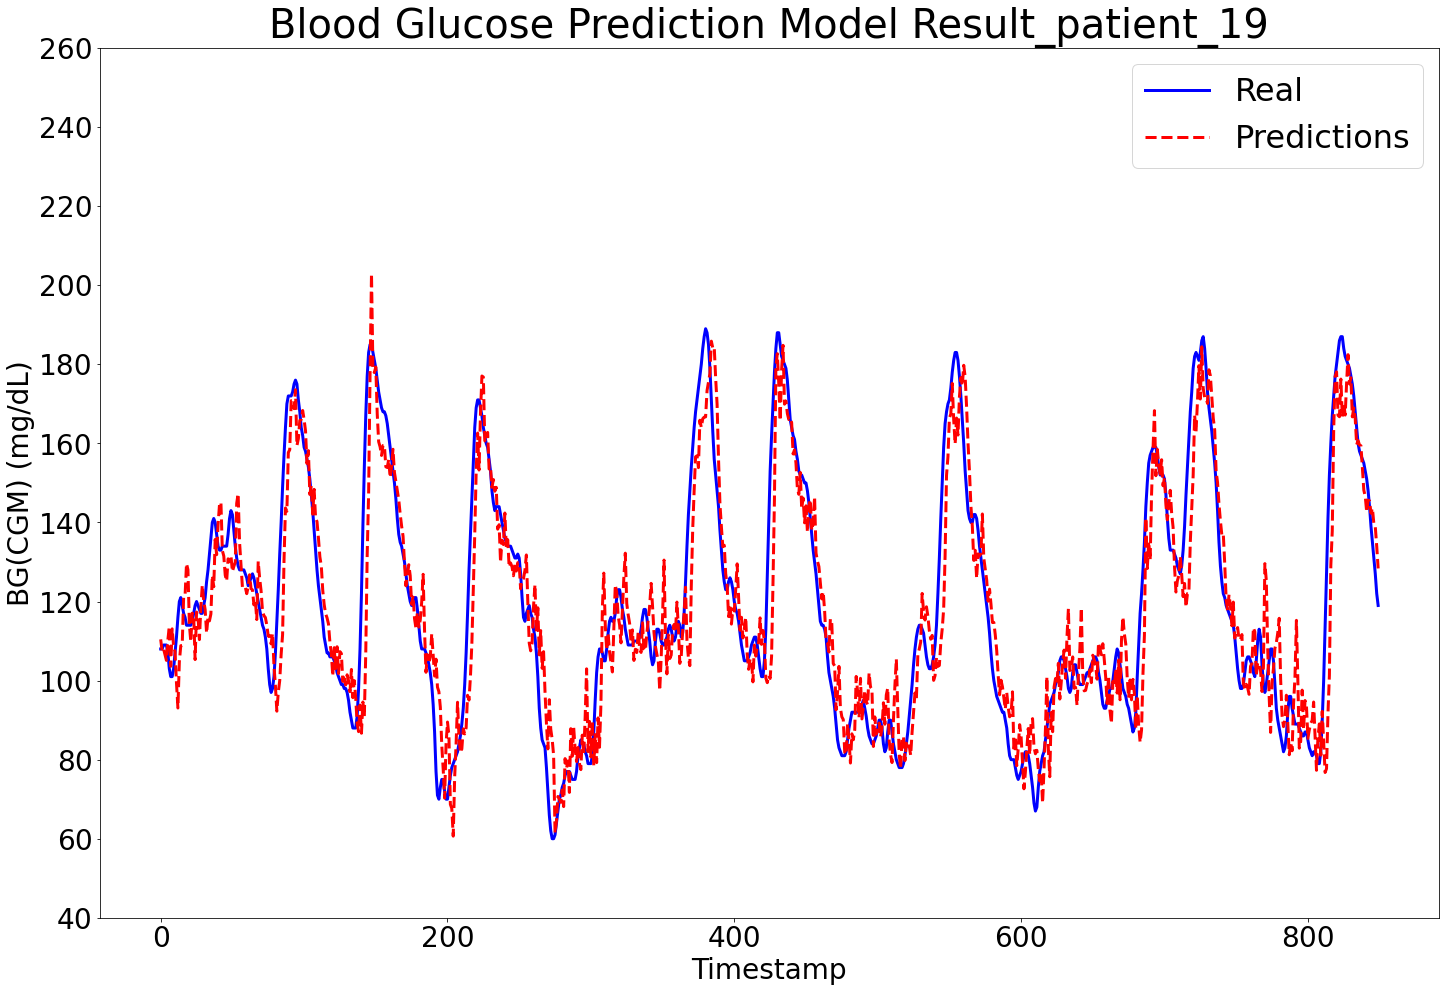

0.93755050307029
0.9617442644669845
0.9760146855950932
Time_delay(min):  15
Root-Mean-Squared Deviation 13.128966498947369
Mean-Absolute-Percentage-Error 8.206690088194431
(850,)
[[116.36512664 119.25016635 114.30463543 118.95580777 129.3882895
  136.30733709 140.61427106 132.66220569 124.97001517 110.85869874
  123.71972661 121.003695   120.63764431 115.69549753 113.53027481
  108.31496676 103.37431036 101.42153679 100.19568833 100.33226619
   96.02892958  97.41627775 104.38673573 109.97656489 111.48443874
  113.16173928  99.25126357  92.07523187 109.30117644 112.37965812
  114.04925984 115.74684691 120.20433741 117.06773105 120.69419718
  123.23623897 123.9865442  120.29526627 129.22541531 123.64812674
  124.0512812  127.60218044 132.29229023 120.67685747 120.20706766
  114.66496258 113.73498977 111.15481104 108.08814892 110.06104652
  111.98786606 106.81101296 101.53542059  94.2157262   87.2809818
  100.05947733 105.28776529 110.14181017 114.74698743 105.00090886
  111.99104293 117.

<ipython-input-7-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


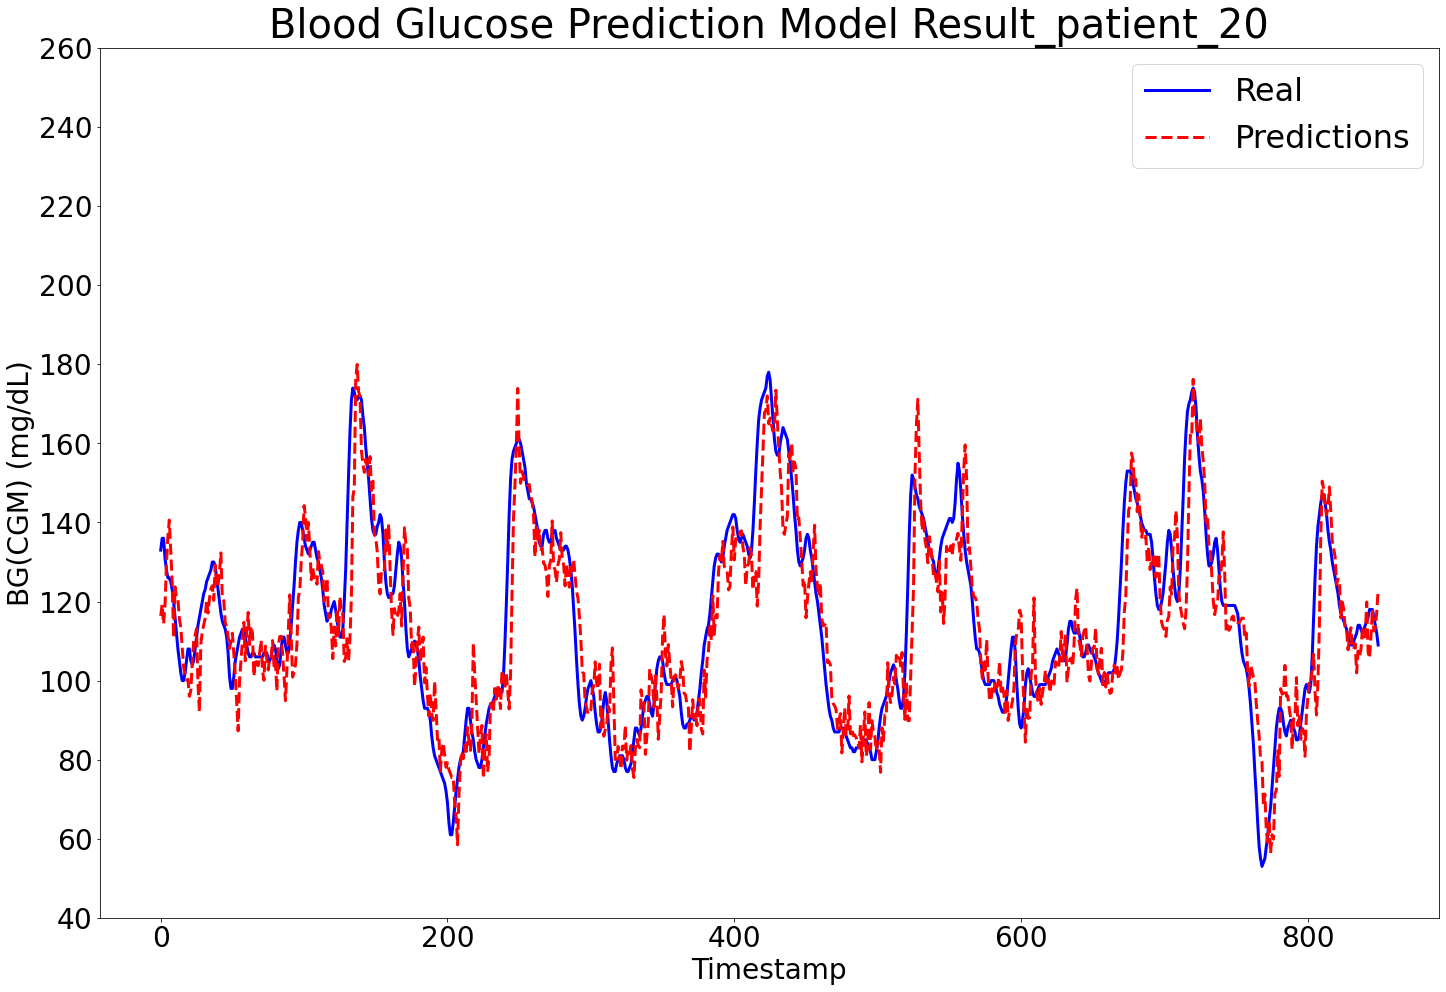

0.9156319586992607
0.946974234866467
0.9685970068234293
0.974946436305321
Time_delay(min):  20
Root-Mean-Squared Deviation 11.880430902355194
Mean-Absolute-Percentage-Error 7.542542223622402


In [10]:
def get_time_gain(continuous_ytest, continuous_predictions):
    corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6:-6])[0,1]
    max_corr = corr
    #j=1
    max_trans = 0
    for j in range(1, 6):
        trans_corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6+j:-6+j])[0,1] 
        if max_corr < trans_corr:
            max_corr = trans_corr
            print(max_corr)
            max_trans = j
    return max_trans
    

for i in range(16,21):
    rmse, mape, continuous_ytest, continuous_predictions = test_model(svr, i)
    show_plots(i, continuous_ytest, continuous_predictions)
    time_gain = get_time_gain(continuous_ytest, continuous_predictions)
    print("Time_delay(min): ", time_gain*5)
    print("Root-Mean-Squared Deviation {}".format(rmse))
    print("Mean-Absolute-Percentage-Error {}".format(mape))